In [16]:
# Importar paquetes
import merger_tree_tools as mtt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd

In [2]:
# Simulación a usar y datos de galaxia deseada
simu='RefL0100N1504'

snap=28
galid=9517736

In [3]:
# Usuario y contraseña para conectarse a EAGLE DataBase
usr='cht015'
pwd='BH457tfj'

# Descargar todos los IDS necesarios de la galaxia deseada

myIDs=mtt.retrieve_ids(usr,pwd,simu,snap,galid)

# Descargar merger tree completo de la galaxia deseada
# Nombre y alias de la tabla de la cual se quieren descargar datos
table='SubHalo'
table_alias='sub'

# Variables que se quiere descargar. OJO!! Asegurarse que estas variables
# estén en la tabla deseada.
columns=[
         'GalaxyID','LastProgID','TopLeafID','DescendantID',
         'SnapNum','Redshift','Stars_Mass','SF_Mass','SF_Hydrogen','SF_Oxygen',
         'StarFormationRate'
        ]

raw_tree=mtt.download_merger_tree(usr,pwd,simu,myIDs['GalaxyID'],myIDs['LastProgID'],
                                  table=table,table_alias=table_alias,columns=columns)

# NOTA: si ya se tiene descargados en un archivo todas las galaxias de la simu, se puede
#       saltear esta celda, y en su lugar, leer dicho archivo de datos y usar máscaras
#       para seleccionar las galaxias del árbol deseado

In [4]:
# Aplicar condiciones a las galaxias del árbol, si es necesario
mask=(
      (raw_tree['Stars_Mass']>1e6) &
      (raw_tree['SF_Mass']>0) &
      (raw_tree['SF_Hydrogen']>0) &
      (raw_tree['SF_Oxygen']>0)
     )

In [5]:
# Armar arbol sólo con galaxias seleccionadas según condiciones anteriores
tree={}
for key in raw_tree.keys():
    tree[key]=raw_tree[key][mask]
    
print('Number of galaxies in the selected tree: '+str(len(tree['GalaxyID'])))    
    
# Ordeno las galaxias según SnapNum creciente
mask_order=(tree['SnapNum']).argsort()
for key in tree.keys():
    tree[key]=tree[key][mask_order]


Number of galaxies in the selected tree: 162


In [6]:
# Agregar variables al árbol final, si es necesario
tree['sSFR']=tree['StarFormationRate']/tree['Stars_Mass']
tree['SF_logOH']=12+np.log10(tree['SF_Oxygen']/tree['SF_Hydrogen'])-np.log10(16)

## Revisar

In [7]:
# Armo un diccionario con solo la main branch del árbol
main_branch={}
# Select galaxies in the main branch 
mask_main=np.logical_and(tree['GalaxyID']>=myIDs['GalaxyID'],
                         tree['GalaxyID']<=myIDs['TopLeafID']) 

for key in tree.keys():
    main_branch[key]=tree[key][mask_main]

print('Number of galaxies in the main branch of selected tree: '+str(len(main_branch['GalaxyID'])))

Number of galaxies in the main branch of selected tree: 23


In [8]:
# Variables to plot
xplot=tree['SnapNum']
yplot=np.log10(tree['Stars_Mass'])

# Labels of variables to plot
xlabel=r'$SnapNum$'
ylabel=r'$\log(M_\bigstar)~[\rm{M}_\odot]$'

# Variable to colour markers and lines
color_var=tree['Redshift']
color_var_label='z'

# Define colors
cmap=plt.get_cmap('jet')
# Limits of variable used to color-code. Modify if necessary.
vmin=min(color_var)
vmax=max(color_var)
norm=colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
color_plot=cmap(norm(color_var))

# Variables a graficar, solo de la main branch
xplot_main=xplot[mask_main]
yplot_main=yplot[mask_main]
color_plot_main=color_plot[mask_main]

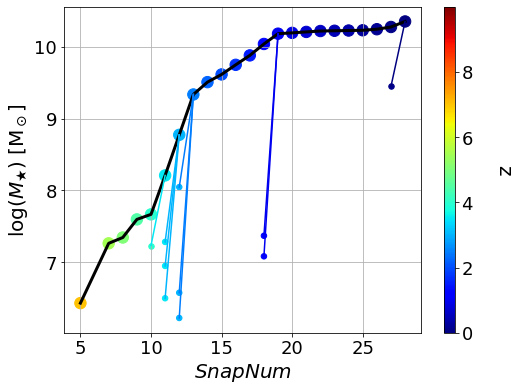

In [9]:
fig,ax=plt.subplots(figsize=(8,6))
    
# Plot main branch
ax.plot(xplot_main,yplot_main,c='k',lw=3)
sc_main=ax.scatter(xplot_main,yplot_main,c=color_plot_main,s=130)

# Vertical color bar with reference to redshifts
sc_main.set_cmap('jet')
sc_main.set_norm(norm)
cbar=fig.colorbar(sc_main, ax=ax, orientation='vertical',shrink=1,pad=0.05,aspect=30)
cbar.set_label(color_var_label,fontsize=20,rotation=270,labelpad=40)
cbar.ax.tick_params(axis='both', which='major', labelsize=18,top=True,bottom=False,
                    labeltop=True,labelbottom=False)

# -------------------------------------------------------------------------------------------

# Galaxias que se fusionan con las de la main branch
plot_main_mergers=True
if plot_main_mergers:
    for i in range(np.size(main_branch['GalaxyID'])):    
        xplot_merge=[]
        yplot_merge=[]
        color_merge=np.array([[1,1,1,1]])  # Lo inicializo así para usar luego vstack
    
        mask=np.where((tree['DescendantID']==main_branch['GalaxyID'][i]))[0]  # estas galaxias incluyen también
                                                                          # al progenitor principal.  
        # Con lo siguiente, se excluye al progenitor principal
        for k in mask:
            if tree['GalaxyID'][k] not in main_branch['GalaxyID']:
                xplot_merge=np.append(xplot_merge,xplot[k])
                yplot_merge=np.append(yplot_merge,yplot[k])
                color_merge=np.vstack((color_merge,color_plot[k]))
        color_merge=np.delete(color_merge,(0),axis=0)
        
        # Scatter plot of galaxies that merge with main branch
        ax.scatter(xplot_merge,yplot_merge,c=color_merge,s=30)
    
        # Lines matching the galaxies with their descendant
        for j in range(len(xplot_merge)):
            ax.plot([xplot_merge[j],xplot_main[i]],[yplot_merge[j],yplot_main[i]],c=color_plot_main[i])

# -------------------------------------------------------------------------------------------     
        
# Tune up the plot
ax.grid()

xmin, xmax = -0.3,8.3
#ax.set_xlim(xmax,xmin)

ymin, ymax= 6.4,10.6
#ax.set_ylim(ymin,ymax)

ax.set_xlabel(xlabel,fontsize=20)
ax.set_ylabel(ylabel,fontsize=20)

ax.tick_params(which='major',axis='both',labelsize=18)

## Calculate level of merger
Considerar la galaxia en la main branch a un dado snapshot k. Considerar también el snapshot anterior k-1. Calcular las siguientes cantidades:

a) Masa de la galaxia (progenitor principal) en el snapshot k-1:

$m_1(k)=M_\star(k-1)+M_{SF}(k-1)$ 
 
b) Suma de masas de galaxias en el snapshot k-1 cuyo descendiente es la galaxia en el snapshot k:

$m_2(k)=\sum\limits_j(M_{\star,j})+\sum\limits_j(M_{SF,j})$

donde cada j corresponde a una galaxia en el snapshot k-1 cuyo descendiente es el progenitor en estudio en el snapshot k (esto incluye, por supuesto, al progenitor principal en el snapshot k-1).

Calculadas las cantidades anteriores, definimos el nivel de merger $L_{merger}$ como:

$L_{merger}(k)=m_2(k)/m_1(k)$

Con esta definición, si $L_{merger}=1$, entonces entre el snapshot k-1 y el snapshot k NO hubo galaxias que se hayan fusionado con la galaxia en estudio.

Por otro lado, si $L_{merger}>1$, entonces hubo fusión entre los snapshots considerados.

INTERPRETACIÓN:

Sea $m_1\equiv M_{main}$, donde $M_{main}$ representa la masa del progenitor principal. Así, se puede escribir que $m_2\equiv M_{main}+M_{merge}$, siendo $M_{merge}$ la suma de las masas de las galaxias que se fusionan con el progenitor principal. Supongamos además que $L_{merger}=1.5$. Entonces:

\begin{equation}
\frac{M_{main}+M_{merge}}{M_{main}}=1.5 \Longrightarrow \frac{M_{merge}}{M_{main}}=0.5
\end{equation}

De lo anterior, resulta entonces que $M_{merge}=0.5 M_{main}$, es decir, la masa de las galaxias que se fusionan con el progenitor principal es el 50\% de la masa de dicho progenitor principal.

In [10]:
xplot_main=main_branch['Redshift']
xlabel='z'

# Calculo level of merger
level_merger=[1]       # Inicializo con un 1, porque la primer galaxia del main branch 
                       # no viene de ninguna fusión...
    
for k in range(np.size(xplot_main)-1):
    m1   = main_branch['Stars_Mass'][k] + main_branch['SF_Mass'][k]
    mask = (tree['DescendantID']==main_branch['GalaxyID'][k+1]) & (tree['SnapNum']!=28)
    # La condición de snapnum distinto a 28 es porque galaxias a z=0 no tienen descendiente,
    # y se les asigna como DescendantID su propio GalaxyID
    m2   = np.sum(tree['Stars_Mass'][mask]) + np.sum(tree['SF_Mass'][mask])
    level= m2/m1
    level_merger=np.append(level_merger,level)  

In [11]:
# Variable a graficar en eje y
yplot_main=level_merger
#yplot_main=np.log10(main_branch['Stars_Mass'])
#yplot_main=np.log10(main_branch['StarFormationRate'])

ylabel=r'$L_{\rm{merger}}$'
#ylabel=r'$\log(M_\bigstar)~[\rm{M}_\odot]$'
#ylabel=r'$\log(SFR)~[\rm{M}_\odot~\rm{yr}^{-1}]$'

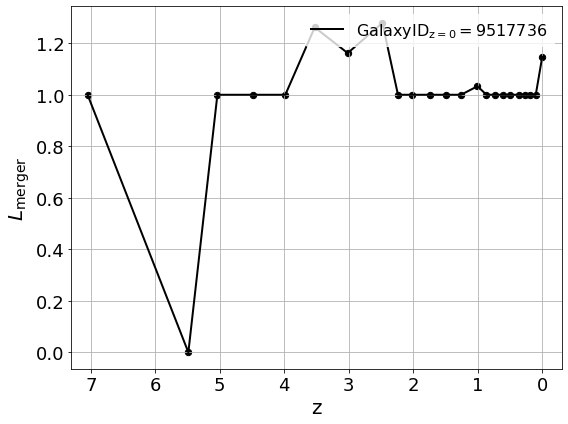

In [12]:
# Graficar level of merger vs. redshift

fig2,ax2=plt.subplots(figsize=(8,6))
#ax2.set_xlim(4.1,-0.1)
ax2.plot(xplot_main,yplot_main,c='k',lw=2,
         label=r'$\rm{GalaxyID}_{z=0}=$'+str(galid))
ax2.scatter(xplot_main,yplot_main,color='k',s=40)

ax2.set_xlabel(xlabel,fontsize=20)
ax2.set_ylabel(ylabel,fontsize=20)

ax2.tick_params(which='major',axis='both',labelsize=18)
ax2.grid()
ax2.legend(loc='upper right',fontsize=16,edgecolor='w')

xmin, xmax = -0.3,7.3
ax2.set_xlim(xmax,xmin)

ymin,ymax=0.95,1.65
#ax2.set_ylim(ymin,ymax)

# Adjust subplots
plt.tight_layout()

In [21]:
# main_branch

In [24]:
# tree

In [26]:
# level_merger

array([1.        , 0.        , 1.        , 1.        , 1.        ,
       1.26159549, 1.16183674, 1.27910912, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.03311682, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.14753509])